In [1]:
from fiveLinkBiped_model import FiveLinkBiped
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Load Matlab data
qs = np.genfromtxt('five_link_biped_qs.csv', delimiter=',')
dqs = np.genfromtxt('five_link_biped_dqs.csv', delimiter=',')
us = np.genfromtxt('five_link_biped_controls.csv', delimiter=',')

In [3]:
init_q = qs[:, 0][np.newaxis, np.newaxis, :]
init_dq = dqs[:, 0][np.newaxis, np.newaxis, :]
states = np.concatenate([init_q, init_dq], axis=2)
states = np.concatenate([states, states], axis=0)
states = tf.cast(states, dtype=tf.float32)

In [4]:
biped = FiveLinkBiped()
biped.batch_size = 2
# biped.update_joint_n_com_pos(init_q)
f = biped.get_drift(states)
g = biped.get_control_influence(states)

# have size [batch_size, 5, 1]
A = biped.get_mass_torque()
# have size [batch_size, 5, 5] and [batch_size, 5, 5]
B, C = biped.get_angular_momentum_change()

In [25]:
f[0, :, :].T + g[0, :, :]

(TensorShape([2, 1, 5]), TensorShape([2, 5, 5]))

In [23]:
C[0, :, :]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[14.35995   , 13.280019  , 10.922801  ,  0.43159837,  0.8904679 ],
       [ 7.3052    ,  8.28319   ,  7.5989056 ,  1.2991664 ,  1.0384225 ],
       [ 2.3083723 ,  2.0212402 ,  4.8324995 ,  1.9364977 ,  1.1462572 ],
       [-1.0155226 , -0.7451658 ,  0.        ,  1.9364977 ,  1.1462572 ],
       [-0.14795452, -0.10783472,  0.        ,  0.16382836,  0.9824288 ]],
      dtype=float32)>

In [7]:
mass_list = [
            biped.m1, biped.m2, biped.m3, biped.m4, biped.m5
]
com_list = [
    biped.g1, biped.g2, biped.g3, biped.g4, biped.g5
]
joint_list = [
    biped.p0, biped.p1, biped.p2, biped.p2, biped.p4
]

_j_vec = tf.constant([[0., 1., 0.]])
# have size [batch_size, 3]
j_vec = tf.tile(_j_vec, [2, 1])

mass_torque_mat = tf.zeros([2, 0])
for j in range(5):
    # have size [batch_size, 3]
    mass_torque = tf.zeros_like(j_vec)
    for i in range(j, 5):
        # have size [batch_size, 3]
        com2point = tf.squeeze(com_list[i] - joint_list[j])
        weight_vec = -mass_list[i] * 9.81 * j_vec
        # have size [batch_size, 3]
        mass_torque += tf.linalg.cross(com2point, weight_vec)

    print(mass_torque)
    # Has shape [batch_size, j+1]
    mass_torque_mat = tf.concat(
        [mass_torque_mat, mass_torque[:, 2:]], 1)

tf.Tensor(
[[ 0.      0.     75.1764]
 [ 0.      0.     75.1764]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 0.        0.       62.133152]
 [ 0.        0.       62.133152]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 0.         0.        -1.1567559]
 [ 0.         0.        -1.1567559]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[0.       0.       9.371138]
 [0.       0.       9.371138]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[0.       0.       1.410268]
 [0.       0.       1.410268]], shape=(2, 3), dtype=float32)


In [5]:
C[0, :, :]

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[14.35995   , 13.280019  , 10.792118  ,  0.52274895,  0.93      ],
       [ 7.3052    ,  8.28319   ,  7.933173  ,  1.0733213 ,  0.93      ],
       [ 2.3083723 ,  2.0212402 ,  5.5083275 ,  1.4769263 ,  0.93      ],
       [-3.4595628 , -2.779288  ,  1.4565328 ,  2.4021082 ,  0.93      ],
       [-0.14795452, -0.10783472,  0.16382836,  0.05242881,  0.93      ]],
      dtype=float32)>

In [14]:
# init_dq[0, :, :].T
# us[:, :1]
init_dq[0, :, :].T

array([[-1.50054228],
       [-0.61150594],
       [ 0.01605327],
       [-0.55071748],
       [-2.00958026]])

In [22]:
# A[0, :, :].numpy() + us[:, :1]
# A[0, :, :].numpy() - B[0, :, :].numpy() @ (init_dq[0, :, :].T)**2 + us[:, :1]
# B[0, :, :].numpy() @ np.array([[2.0], [3.0], [5.0], [4.0], [8.0]]) ** 2

array([[73.20603665],
       [35.2387927 ],
       [50.01959988],
       [12.02737143],
       [16.00558675]])

In [21]:
gp = (biped.g5[0, :, :] - biped.p4[0, :, :])
mg = -biped.m5 * 9.81 * tf.constant([[0.0], [1.0], [0.0]], dtype=tf.float32)

gp = tf.transpose(gp, perm=[1, 0])
mg = tf.transpose(mg, perm=[1, 0])

tf.linalg.cross(gp, mg)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.      , -0.      ,  1.410268]], dtype=float32)>

In [25]:
gp1 = (biped.g5[0, :, :] - biped.p2[0, :, :])
mg1 = -biped.m5 * 9.81 * tf.constant([[0.0], [1.0], [0.0]], dtype=tf.float32)

gp1 = tf.transpose(gp1, perm=[1, 0])
mg1 = tf.transpose(mg1, perm=[1, 0])

cr1 = tf.linalg.cross(gp1, mg1)

gp1 = (biped.g4[0, :, :] - biped.p2[0, :, :])
mg1 = -biped.m4 * 9.81 * tf.constant([[0.0], [1.0], [0.0]], dtype=tf.float32)

gp1 = tf.transpose(gp1, perm=[1, 0])
mg1 = tf.transpose(mg1, perm=[1, 0])

cr2 = tf.linalg.cross(gp1, mg1)

cr1 + cr2

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.      , -0.      ,  9.371138]], dtype=float32)>

In [35]:
controls = us[:, 0][np.newaxis, np.newaxis, :]
controls = np.concatenate([controls, controls], axis=0)
controls = tf.cast(controls, dtype=tf.float32)
controls

TensorShape([2, 1, 5])

In [58]:
gu = g @ tf.transpose(controls, perm=[0, 2, 1])
dx = f + tf.transpose(gu, perm=[0, 2, 1])
dx

<tf.Tensor: shape=(2, 1, 5), dtype=float32, numpy=
array([[[ 13.990587 , -16.476906 ,   7.045702 ,  -2.0493584,
          16.399292 ]],

       [[ 13.990587 , -16.476906 ,   7.045702 ,  -2.0493584,
          16.399292 ]]], dtype=float32)>

In [45]:
d_x = tf.concat([states[:, :, 5:], dx], axis=2)

states += d_x * 0.02

In [48]:
biped.update_joint_n_com_pos(states[:, :, :5])

In [50]:
n = 1
joints = [biped.p0, biped.p1, biped.p2, biped.p3, biped.p4, biped.p5]
joint_plot = np.zeros((3, 7))
for i, num in enumerate([0, 1, 2, 3, 2, 4, 5]):
    joint_plot[:, i] = joints[num][n, :, :].numpy()[:, 0]

(-0.5, 2.0)

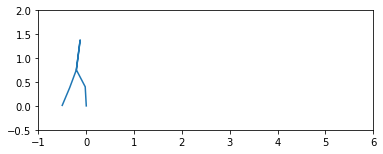

In [51]:
plt.figure()
plt.plot(joint_plot[0, :], joint_plot[1, :])
plt.gca().set_aspect('equal')
plt.xlim([-1, 6])
plt.ylim([-0.5, 2])

In [54]:
init_q, init_dq

(array([[[ 0.08538608,  0.49380067, -0.12659436, -0.34667185,
          -0.3586091 ]]]),
 array([[[-1.50054228, -0.61150594,  0.01605327, -0.55071748,
          -2.00958026]]]))

In [57]:
us[:, 0]

array([  0.        , -23.71004274,  50.2053136 ,   4.03502113,
        14.79931518])